In [45]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import scipy.optimize as opt
import scipy.interpolate as interp
from scipy.stats import norm
from numba import jit, njit, int32, float64
import quantecon as qe

import seaborn as sns
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import Axes3D

import eurostat

In [46]:
m = {
    'Jan': 1,
    'Feb': 2,
    'Mar': 3,
    'Apr': 4,
    'May': 5,
    'Jun': 6,
    'Jul': 7,
    'Aug': 8,
    'Sep': 9,
    'Oct': 10,
    'Nov': 11,
    'Dec': 12
}

In [151]:
gdp = eurostat.get_data_df('namq_10_gdp')
gdp

,unit,s_adj,na_item,geo\time,2020Q3,2020Q2,2020Q1,2019Q4,2019Q3,2019Q2,...,1977Q2,1977Q1,1976Q4,1976Q3,1976Q2,1976Q1,1975Q4,1975Q3,1975Q2,1975Q1
0,CLV05_MEUR,CA,B1G,AT,NaN,59090.8,66028.6,71736.3,69367.5,68603.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CLV05_MEUR,CA,B1G,CH,NaN,94108.0,100620.7,104762.0,103741.0,103484.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CLV05_MEUR,CA,B1G,CY,NaN,3718.4,4014.1,4240.4,4249.7,4232.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CLV05_MEUR,CA,B1G,CZ,NaN,31921.2,32923.8,36172.2,35847.5,35785.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CLV05_MEUR,CA,B1G,FI,NaN,39242.7,38542.3,42061.6,40664.5,41387.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48498,PYP_MNAC,SCA,YA1,IE,NaN,1117.4,-1473.4,1140.0,-2150.2,-1138.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48499,PYP_MNAC,SCA,YA1,IT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48500,PYP_MNAC,SCA,YA1,LU,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48501,PYP_MNAC,SCA,YA1,LV,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
ue_df = eurostat.get_data_df('tipsun30')
ue_df = ue_df[ue_df['geo\\time'].str.match('FI') & ue_df['unit'].str.match('PC_ACT')]
ue_df = ue_df.drop(ue_df.columns[:list(ue_df.columns).index('2008Q1')], axis=1)
ue_df.head()

,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
10,6.3,6.2,6.3,6.6,7.2,8.4,8.5,8.9,8.8,8.4,...,8.3,7.2,7.2,6.7,6.7,6.6,6.8,6.8,6.8,7.7


In [86]:
EMU_conv_df = eurostat.get_data_df('irt_lt_mcby_q')
EMU_conv_df = EMU_conv_df[EMU_conv_df['geo\\time'].str.match('FI')]
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:3], axis=1).iloc[:,::-1]
EMU_conv_df = EMU_conv_df.drop(EMU_conv_df.columns[:list(EMU_conv_df.columns).index('2008Q1')], axis=1)
EMU_conv_df.head()

,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
13,4.07,4.49,4.56,4.05,3.87,3.89,3.67,3.52,3.38,3.1,...,0.74,0.67,0.58,0.65,0.41,0.21,-0.25,-0.11,-0.14,-0.09


In [137]:
cpi = eurostat.get_data_df('tec00118')
cpi = cpi[cpi['geo\\time'].str.match('FI')]
cpi = cpi.drop(cpi.columns[:3], axis=1)
cpi_q = pd.DataFrame(columns=ue_df.columns, index=[1])
for i in a.columns:
    if int(i[:4]) in list(cpi.columns):
        cpi_q.loc[1,i] = cpi.loc[cpi.index[0], int(i[:4])] ** (1/4)
cpi = cpi_q
cpi.head()

,2008Q1,2008Q2,2008Q3,2008Q4,2009Q1,2009Q2,2009Q3,2009Q4,2010Q1,2010Q2,...,2018Q1,2018Q2,2018Q3,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2
1,1.40529,1.40529,1.40529,1.40529,1.12468,1.12468,1.12468,1.12468,1.14186,1.14186,...,1.04664,1.04664,1.04664,1.04664,1.02411,1.02411,1.02411,1.02411,NaN,NaN


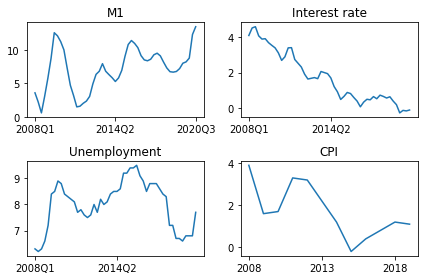

In [89]:
fig, axs = plt.subplots(2,2)
axs[0,0].plot(mq_aggregate_df.iloc[0])
axs[0,0].set_xticks([i for e, i in enumerate(mq_aggregate_df.columns) if e % 25 == 0])
axs[0,0].set_title('M1')
axs[1,0].plot(ue_df.iloc[0])
axs[1,0].set_title('Unemployment')
axs[1,0].set_xticks([i for e, i in enumerate(ue_df.columns) if e % 25 == 0])
axs[0,1].plot(EMU_conv_df.iloc[0])
axs[0,1].set_title('Interest rate')
axs[0,1].set_xticks([i for e, i in enumerate(EMU_conv_df.columns) if e % 25 == 0])
axs[1,1].plot(cpi.iloc[0])
axs[1,1].set_title('CPI')
axs[1,1].set_xticks([i for e, i in enumerate(cpi.columns) if e % 5 == 0])
fig.tight_layout()

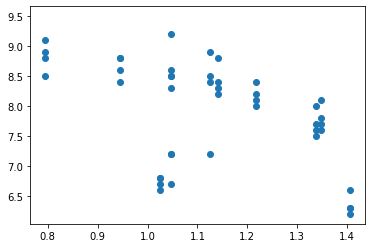

In [147]:
plt.scatter(cpi.iloc[0], ue_df.iloc[0])

mq_aggregate_df, ue_df, EMU_conv_df, cpi

In [149]:
mq_aggregate_df, ue_df, EMU_conv_df, cpi
c_mq_aggregate_df, t_mq_aggregate_df= sm.tsa.filters.hpfilter(mq_aggregate_df, 1600)

ValueError: x is required to have ndim 1 but has ndim 2